In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime as dt
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def load_data():
    games = pd.read_csv('data/games.csv').sort_values(by='date')
    atbats = pd.read_csv('data/atbats.csv')
    pitches = pd.read_csv('data/pitches.csv')
    
    ptypes = ['FF','SL','FT','SI','CH','CU','FC','KC','FS','KN']
    pitches = pitches[pitches.type.map(lambda t: t in ptypes)]
    pitches = pitches[pitches.balls < 4]

    out = ['Strikeout', 'Groundout', 'Flyout', 'Pop Out', 'Lineout', 'Forceout', 'Grounded Into DP', 'Field Error', 'Sac Bunt', 'Sac Fly', 'Bunt Groundout', 'Fielders Choice Out', 'Bunt Pop Out', 'Strikout - DP', 'Fielders Choice', 'Sac Fly DP', 'Bunt Lineout', 'Triple Play', 'Sacrifice Bunt DP', 'Walk', 'Hit By Pitch', 'Intent Walk']
    hit = ['Single', 'Double', 'Triple', 'Home Run']
    # bad = ['Runner Out', 'Fan interference', 'Batter Interference', 'Catcher Interference']

    ball = ['Ball', 'Ball In Dirt', 'Intent Ball', 'Pitchout', 'Automatic Ball']
    strike = ['Called Strike', 'Swinging Strike', 'Foul Tip', 'Swinging Strike (Blocked)', 'Foul Bunt', 'Missed Bunt', 'Swinging Pitchout', 'Automatic Strike']
    foul = ['Foul', 'Foul (Runner Going)', 'Foul Pitchout']
    inplay = ['In play, out(s)', 'In play, no out', 'In play, run(s)', 'Hit By Pitch']

    des = lambda x: 'ball' if x in ball else 'strike' if x in strike else 'foul' if x in foul else 'inplay' if x in inplay else 'error'
    evt = lambda x: 'out' if x in out else 'hit' if x in hit else 'error'
    
    atbats.event = atbats.event.map(evt)
    atbats = atbats[atbats.event != 'error']

    pitches.des = pitches.des.map(des)
    pitches = pitches[pitches.des != 'error']
    pitches = pitches[(pitches.x > 0) & (pitches.y > 0)] # is this necessary?
    
    games['night'] = games.time_et.map(lambda s: dt.datetime.strptime(s, '%I:%M %p').time() > dt.time(18,0)).astype(int)
    # games['month'] = games.date.map(lambda s: dt.datetime.strptime(s, '%Y-%m-%d').month)

    atbats['home'] = atbats.inning_half.map({'top':0,'bottom':1})
    games = games[games.game_type == 'R']
    games['date'] = pd.to_datetime(games.date)
    pitches = pitches[pd.notnull(pitches.type)]
    atbats = games.merge(atbats, on='game_id')
    
    atbats['weekday'] = atbats.date.map(lambda t: t.weekday())
    atbats['month'] = atbats.date.map(lambda t: t.month)
    
    atbats.loc[atbats.home==0, 'batter_team'] = atbats[atbats.home==0].away_team
    atbats.loc[atbats.home==1, 'batter_team'] = atbats[atbats.home==1].home_team
    atbats.loc[atbats.home==0, 'pitcher_team'] = atbats[atbats.home==0].home_team
    atbats.loc[atbats.home==1, 'pitcher_team'] = atbats[atbats.home==1].away_team

    pitches = atbats.merge(pitches, on=['game_id', 'ab_num'])
    pitches.loc[pitches.des=='inplay', 'des'] = pitches.loc[pitches.des=='inplay', 'event']

    return pitches
    
    

In [12]:
pitches = load_data()
print('Data loaded: %d pitches' % pitches.shape[0])

Data loaded: 3484355 pitches


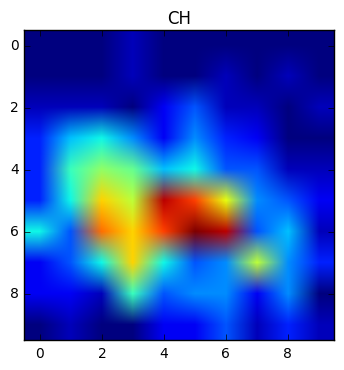

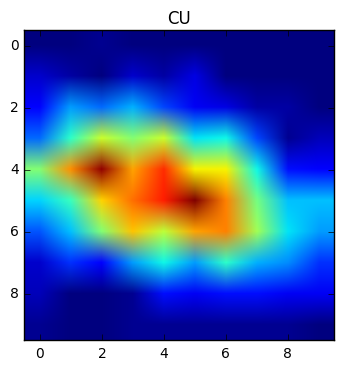

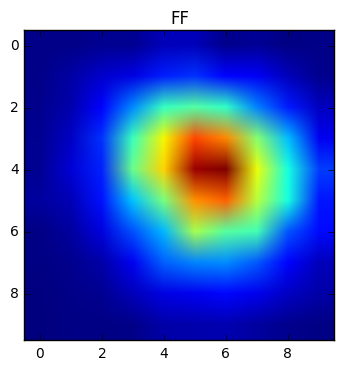

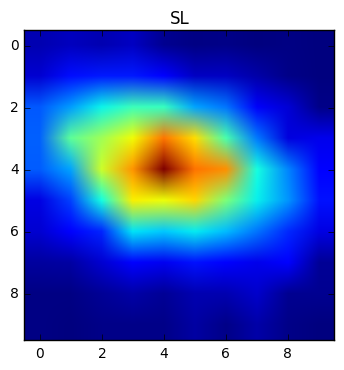

16205
FF    0.633076
SL    0.240852
CU    0.099105
CH    0.026967
Name: type, dtype: float64


In [11]:
kershaw = pitches[pitches.pitcher_id == 477132]
xbound = np.percentile(pitches.px, [1,99])
ybound = np.percentile(pitches.pz, [1,99])

for ptype, subset in kershaw.groupby('type'):
    plocs,_,_ = np.histogram2d(subset.px.values, subset.pz.values, range=[xbound, ybound])
    plt.imshow(plocs)
    plt.title(ptype)
    plt.show()
    
print(kershaw.shape[0])
print(kershaw.type.value_counts(normalize=True))

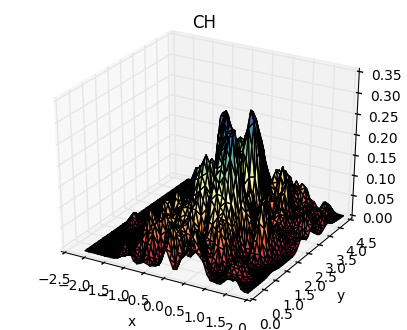

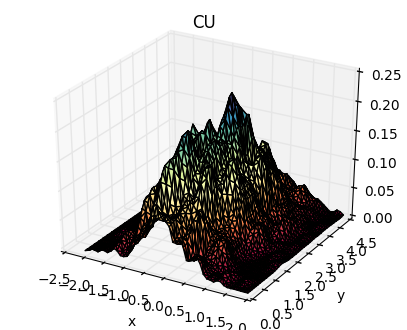

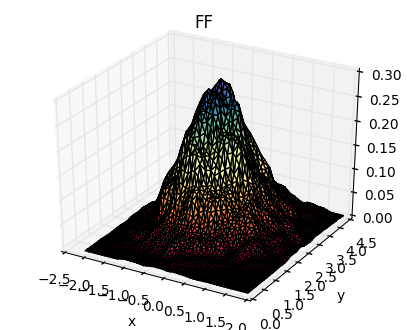

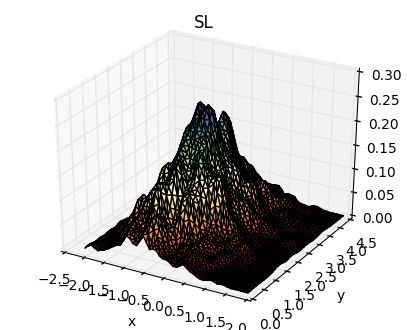

In [5]:
x,y = zip(*[(x,y) for x in np.linspace(xbound[0], xbound[1]) for y in np.linspace(ybound[0], ybound[1])])
locs = np.vstack([x,y])
bw = 0.12
for ptype, subset in kershaw.groupby('type'):
    kde = stats.gaussian_kde([subset.px, subset.pz], bw_method=bw)
    z = kde(locs)
    fig = plt.figure(figsize=[5,4])
    ax = fig.add_subplot(1,1,1, projection='3d')
    ax.plot_trisurf(x,y,z,cmap=cm.Spectral) # PDF of Kershaws pitch locations
    plt.xlabel('x'); plt.ylabel('y');
    plt.title(ptype)


In [35]:
cols = ['time_et', 'date', 'away_team', 'home_team', 'year', 'pitcher_id', 'batter_id', 'b_stand', 'p_throws', 'inning', 'order', 'balls', 'strikes', 'type', 'px', 'pz']
pitches[cols].sample(5)

,time_et,date,away_team,home_team,year,pitcher_id,batter_id,b_stand,p_throws,inning,order,balls,strikes,type,px,pz
1610960,07:05 PM,2012-06-01,Twins,Indians,2012,488846,430946,R,L,8,4,0,0,SL,0.386,2.091
3404570,08:10 PM,2014-09-08,Athletics,White Sox,2014,543243,547989,R,R,5,3,1,2,SL,1.978,-0.035
2686565,08:10 PM,2013-09-04,Mariners,Royals,2013,451584,116380,L,R,5,5,1,1,FC,-0.981,1.434
1123249,04:10 PM,2011-07-23,Tigers,Twins,2011,207267,430585,L,R,1,5,0,1,FS,-0.421,0.776
86815,08:05 PM,2010-04-27,White Sox,Rangers,2010,450351,435041,R,L,2,6,1,2,CH,1.451,1.328
